In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of Article Category Specific Features: Disasters by Deaths and GDP per capita

In [ ]:
import pandas as pd
import numpy as np
import requests as rq
from regression import transform_vars_for_regression

## Retrieving deaths and injured from WikiData

In [27]:
# Note: You do not have to run this, you can just load the prepared dataframe here:
df_disasters = pd.read_csv('events/extended/df_disasters.csv')
df_disasters = transform_vars_for_regression(df_disasters)

In [ ]:
# Just to show how info is loaded from WikiData:

In [3]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews_allcorr.csv').drop_duplicates().drop(['Unnamed: 0'], axis=1)
df_disasters = df_crawled[df_crawled.cat == 'disaster']
df_disasters = transform_vars_for_regression(df_disasters)

# Retrieve disaster info from Wikidata
dict_jsons = {}
for qid in df_disasters.event_id.unique():
    rec_json = rq.get(f'https://www.wikidata.org/wiki/Special:EntityData/{qid}.json').json()
    dict_jsons[qid] = rec_json

# Extract PIDS
#  number of survivors (P1561) 
#  number of injured (P1339) 
#  number of deaths (P1120) 
def get_dataval(entity, property_id):
    if 'claims' in entity:
        entity = entity['claims']
        if property_id in entity:
            dataval = entity[property_id][0]['mainsnak']
            if 'datavalue' in dataval:
                return int(dataval['datavalue']['value']['amount'].replace('+', ''))
            else:
                return None # Unknown
    return None

pd_data = []
for key, vals in dict_jsons.items():
    entity = list(vals['entities'].values())[0]
    survivors, injured, deaths = \
        get_dataval(entity, 'P1561'), get_dataval(entity, 'P1339'), get_dataval(entity, 'P1120')
    pd_data.append([key, survivors, injured, deaths])
df_casualties = pd.DataFrame(pd_data, columns=['event_id', 'survivors', 'injured', 'deaths'])

# Merge DF
df_disasters = df_disasters.merge(df_casualties.fillna(0), on='event_id')
df_disasters = transform_vars_for_regression(df_disasters)
df_disasters['casualties'] = df_disasters.deaths + df_disasters.injured
df_disasters['deaths_log'] = np.log1p(df_disasters.deaths)
df_disasters['casualties_log'] = np.log1p(df_disasters.casualties)
df_disasters['injured_log'] = np.log1p(df_disasters.injured)
df_disasters.to_csv('events/extended/df_disasters.csv', index=False)

## Fit XGB Tree and Compute SHAP values for Experiment

In [28]:
from xgboost import XGBRegressor
from prediction import ModelEvaluator
import shapash
import shap

In [79]:
df_disasters_reg

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,diff_days,year,...,views_baseline_log,bing_hits_log,GDP_pc_log,GDP_log,GDP_pc_log_z,population_log,population_z,casualties,deaths_log,views_7_sum_log
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",0,2016,...,18.262470,2.484907,7.218074,26.349163,-0.422171,19.131822,0.069188,47.0,3.871201,12.422292
1,Q100021,Pakistan-International-Airlines-Flug 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Kategorie:ATR 42', 'Kategorie:Flugunfall 201...",0,2016,...,11.010415,10.094149,7.218074,26.349163,-0.422171,19.131822,0.069188,47.0,3.871201,9.737020
2,Q100021,Volo Pakistan International Airlines 661,2016-12-07,Global South,Pakistan,Asia,disaster,['Categoria:Incidenti e disastri aerei con cau...,1,2016,...,10.419331,2.708050,7.218074,26.349163,-0.422171,19.131822,0.069188,47.0,3.871201,6.507278
3,Q100021,Vuelo 661 de Pakistan International Airlines,2016-12-07,Global South,Pakistan,Asia,disaster,['Categoría:Accidentes e incidentes aéreos de ...,0,2016,...,10.757924,4.442651,7.218074,26.349163,-0.422171,19.131822,0.069188,47.0,3.871201,8.210940
4,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",0,2020,...,21.871267,8.805525,11.052850,30.670471,1.429815,19.613039,0.487454,0.0,0.000000,11.213778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Q56318493,Milagro de Durango,2018-08-01,Global South,Mexico,North America,disaster,"['Categoría:Desastres en México', 'Categoría:H...",1,2018,...,19.198596,8.074338,9.178591,27.831793,0.213241,18.653305,-0.188182,80.0,0.000000,5.587249
1950,Q83819921,Ataque a la embajada estadounidense en Irak de...,2020-01-26,Global South,Iraq,Asia,disaster,['Categoría:Ataques contra misiones diplomátic...,2,2020,...,10.043293,9.182044,8.330108,25.839803,-0.640467,17.509937,-0.473894,0.0,0.000000,5.872118
1953,Q87472074,Colisión de trenes en el Metro de la Ciudad de...,2020-03-10,Global South,Mexico,North America,disaster,['Categoría:Accidentes del Metro de la Ciudad ...,1,2020,...,19.160721,10.354595,9.027207,27.701888,0.157568,18.674802,-0.179069,42.0,0.693147,7.223296
1955,Q97487937,Terremoto de Iquique de 2020,2020-07-17,Global South,Chile,South America,disaster,"['Categoría:Chile en 2020', 'Categoría:Desastr...",1,2020,...,18.020740,4.488636,9.490447,26.256418,-0.461918,16.766047,-0.544039,0.0,0.000000,5.529429


In [181]:
df_disasters_reg = df_disasters[df_disasters.views_7_sum > 10]
df_disasters_reg['views_7_sum_log'] = np.log1p(df_disasters_reg.views_7_sum)
df_disasters_reg.event_date = pd.to_datetime(df_disasters_reg.event_date)

In [203]:
# fit model via random search
param_grid_xgboost_reg = {'max_depth': [4, 5, 6, 10, 15, 20],
                      'n_estimators': [10, 100, 500, 1000],
                      'learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
                      'gamma': [0, 1, 2, 5, 10],
                       'reg_lambda': [0, 1, 10],
                       'scale_pos_weight': [0.05, 0.1, 1, 2]}

xgb_disasters = ModelEvaluator(XGBRegressor(n_jobs=144), df_disasters_reg, 'views_7_sum_log', 
                               'neg_mean_squared_error', params=param_grid_xgboost_reg, 
                               cont_cols = ['GDP_pc_log', 'deaths_log', 'country_articles_log', 'population_log', 'cat_articles_log', 
                                             'view_country_article_log', 'views_baseline_log'],
                               factor_cols=['code'])
xgb_disasters.random_search(n_jobs=1, n_iter=100)
#xgb_disasters.grid_search(n_jobs=1)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          n_estimators=100, n_jobs=144,
                                          num_parallel_tree=None,
                                          predict

In [208]:
# fit model via random search
param_grid_xgboost_reg = {'max_depth': [4, 5, 6, 10, 15, 20],
                      'n_estimators': [10, 100, 500, 1000],
                      'learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
                      'gamma': [0, 1, 2, 5, 10],
                       'reg_lambda': [0, 1, 10],
                       'scale_pos_weight': [0.05, 0.1, 1, 2]}

xgb_disasters_plain = ModelEvaluator(XGBRegressor(n_jobs=144), df_disasters_reg, 'views_7_sum_log', 
                               'neg_mean_squared_error', params=param_grid_xgboost_reg, 
                               cont_cols = ['country_articles_log', 'population_log', 'cat_articles_log', 
                                             'view_country_article_log', 'views_baseline_log'],
                               factor_cols=['code'])
xgb_disasters_plain.random_search(n_jobs=1, n_iter=100)
#xgb_disasters_plain.grid_search(n_jobs=1)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          n_estimators=100, n_jobs=144,
                                          num_parallel_tree=None,
                                          predict

In [229]:
# fit model via random search
param_grid_xgboost_reg = {'max_depth': [4, 5, 6, 10, 15, 20],
                      'n_estimators': [10, 100, 500, 1000],
                      'learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
                      'gamma': [0, 1, 2, 5, 10],
                       'reg_lambda': [0, 1, 10],
                       'scale_pos_weight': [0.05, 0.1, 1, 2]}

xgb_disasters_simple = ModelEvaluator(XGBRegressor(n_jobs=144), df_disasters_reg, 'views_7_sum_log', 
                               'neg_mean_squared_error', params=param_grid_xgboost_reg, 
                               cont_cols = ['GDP_pc_log', 'deaths_log'],
                               factor_cols=['code'])
xgb_disasters_simple.random_search(n_jobs=1, n_iter=100)
#xgb_disasters_simple.grid_search(n_jobs=1)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          n_estimators=100, n_jobs=144,
                                          num_parallel_tree=None,
                                          predict

In [212]:
xgb_disasters_simple.rs_res.best_score_

-4.711981174365529

In [220]:
xgb_disasters_plain.rs_res.best_params_

{'scale_pos_weight': 2,
 'reg_lambda': 1,
 'n_estimators': 10,
 'max_depth': 4,
 'learning_rate': 0.5,
 'gamma': 0}

In [219]:
xgb_disasters.rs_res

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          n_estimators=100, n_jobs=144,
                                          num_parallel_tree=None,
                                          predict

In [230]:
xgb_disasters_simple.gs_res = xgb_disasters_simple.rs_res
xgb_disasters_simple.retrain_full()

neg_mean_squared_error: 3.1433


3.1433326451954584

In [209]:
xgb_disasters_plain.gs_res = xgb_disasters_plain.rs_res
xgb_disasters_plain.retrain_full()

neg_mean_squared_error: 3.3615


3.361463791069714

In [204]:
xgb_disasters.gs_res = xgb_disasters.rs_res
xgb_disasters.retrain_full()

neg_mean_squared_error: 1.4113


1.4113071508896367

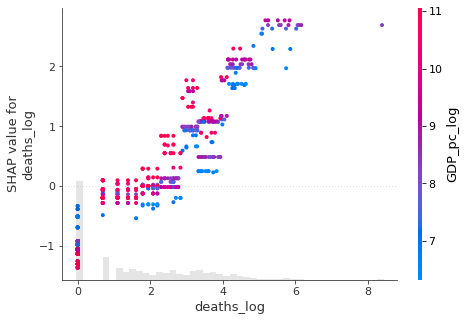

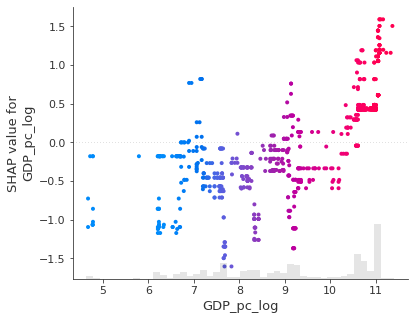

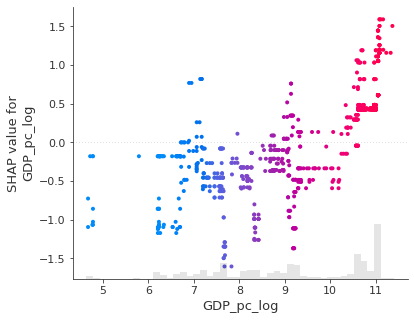

In [228]:
shap.plots.scatter(shap_values[:,"deaths_log"], color=shap_values[:, 'GDP_pc_log'])
shap.plots.scatter(shap_values[:,"GDP_pc_log"], color=shap_values[:, 'code_en'])
shap.plots.scatter(shap_values[:,"GDP_pc_log"], color=shap_values[:, 'code_en'])

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.summary_plot(shap_interaction, df_full)


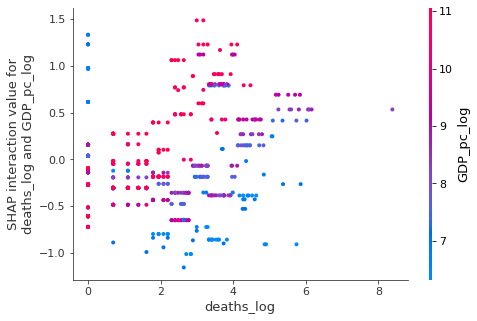

In [225]:

shap.dependence_plot(
    ("deaths_log", "GDP_pc_log"),
    shap_interaction, df_full,
    display_features=df_full[:]
)

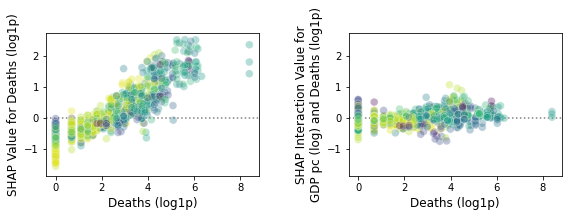

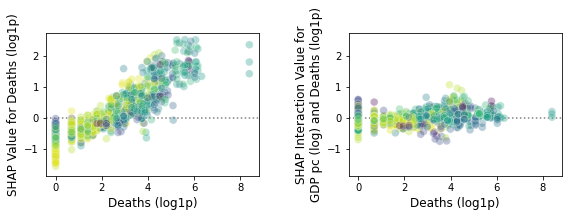

In [223]:
df_full = pd.concat([xgb_disasters.df_train_full, xgb_disasters.df_test])[xgb_disasters.encoded_columns]
explainer = shap.Explainer(xgb_disasters.full_model)
#df_shap = df_full.rename({'GDP_pc_log': 'GDP pc. (log)', 'deaths_log': 'Deaths (log1p)'}, axis=1)
shap_values = explainer(df_full)
shap_interaction = explainer.shap_interaction_values(df_full)
plot_disaster_results(df_full, shap_values, shap_interaction, save_path=None)

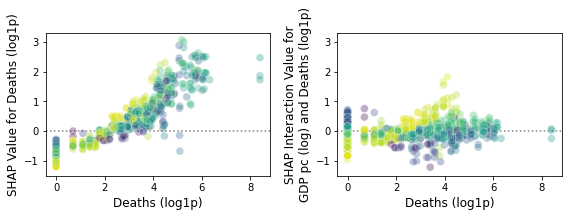

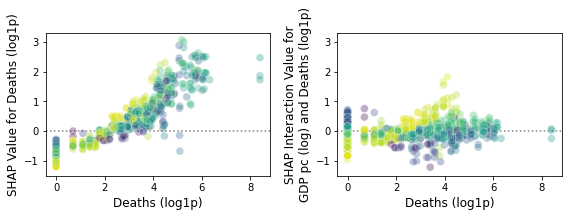

In [231]:
from plot_regression import plot_disaster_results
df_full = pd.concat([xgb_disasters_simple.df_train_full, xgb_disasters_simple.df_test])[xgb_disasters_simple.encoded_columns]
explainer = shap.Explainer(xgb_disasters_simple.full_model)
#df_shap = df_full[['GDP_pc_log', 'deaths_log', 'code']]
shap_values = explainer(df_full)
shap_interaction = explainer.shap_interaction_values(df_full)
plot_disaster_results(df_full, shap_values, shap_interaction, save_path=None,)

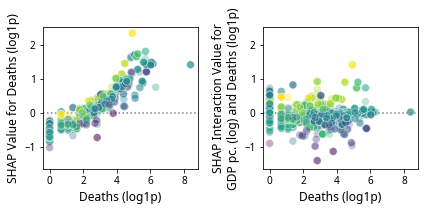

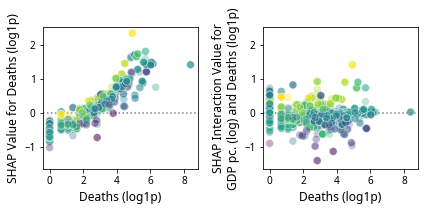

In [352]:
from plot_regression import plot_disaster_results
plot_disaster_results(df_shap_2, shap_values2, shap_interaction2, save_path=None)

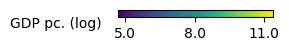

In [39]:
from plot_regression import build_colormap

cmp = build_colormap('GDP pc. (log)', (df_shap['GDP pc. (log)'].min(), df_shap['GDP pc. (log)'].max()), cmap='viridis', labelpad=-13, horizontal=True, adjust_limits=False, save_path='figures/shap/deaths_col_cm.pdf', ticks=[5.0, 8, 11.])